In [1]:
%%capture
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
from tqdm import tqdm
import time
from tabulate import tabulate
from collections import defaultdict
from xgboost import XGBClassifier as XGB
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.preprocessing import minmax_scale, StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.tree import ExtraTreeClassifier as ExtraTree
from sklearn.ensemble import ExtraTreesClassifier as ExtraTrees
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import RidgeClassifier as Ridge
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold

from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier, EasyEnsembleClassifier, BalancedBaggingClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn import svm
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from keras.layers import Activation, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization
from keras.models import Sequential

In [2]:
PREPROCESSED_EXTRACTED_FEATURES_FILE = 'all_preprocessed_extracted_features_iemocap.csv'
pd.options.display.max_columns = None
pd.options.display.max_rows = None
tf.random.set_seed(1)
plt.rcParams['figure.dpi'] = 150

In [3]:
df = pd.read_csv(PREPROCESSED_EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')

df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1

print(f"Number of Audio Files: {df.shape[0]}")
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

Number of Audio Files: 5531


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
happy,1,1636
neutral,3,1708
sad,2,1084


In [4]:
df.head()

,Interaction,Gender,Duration,Emotion,Emotion_Id,Valence,Activation,Dominance,spikes_mel_spect,25thpercentile_mel_spect,median_mel_spect,75thpercentile_mel_spect,mean_mel_spect,min_mel_spect,max_mel_spect,var_mel_spect,std_mel_spect,sum_mel_spect,spikes_chroma_stft,25thpercentile_chroma_stft,median_chroma_stft,75thpercentile_chroma_stft,mean_chroma_stft,var_chroma_stft,std_chroma_stft,sum_chroma_stft,spikes_rms,25thpercentile_rms,median_rms,75thpercentile_rms,mean_rms,max_rms,var_rms,std_rms,sum_rms,spikes_spec_cent,25thpercentile_spec_cent,median_spec_cent,75thpercentile_spec_cent,mean_spec_cent,min_spec_cent,max_spec_cent,var_spec_cent,std_spec_cent,sum_spec_cent,spikes_spec_bw,25thpercentile_spec_bw,median_spec_bw,75thpercentile_spec_bw,mean_spec_bw,min_spec_bw,max_spec_bw,var_spec_bw,std_spec_bw,sum_spec_bw,spikes_spec_rolloff,25thpercentile_spec_rolloff,median_spec_rolloff,75thpercentile_spec_rolloff,mean_spec_rolloff,min_spec_rolloff,max_spec_rolloff,var_spec_rolloff,std_spec_rolloff,sum_spec_rolloff,spikes_spec_cont,25thpercentile_spec_cont,median_spec_cont,75thpercentile_spec_cont,mean_spec_cont,min_spec_cont,max_spec_cont,var_spec_cont,std_spec_cont,sum_spec_cont,spikes_tonnetz,25thpercentile_tonnetz,median_tonnetz,75thpercentile_tonnetz,mean_tonnetz,min_tonnetz,max_tonnetz,var_tonnetz,std_tonnetz,sum_tonnetz,spikes_zcr,25thpercentile_zcr,median_zcr,75thpercentile_zcr,mean_zcr,min_zcr,max_zcr,var_zcr,std_zcr,sum_zcr,kurtosis_mfcc1,skew_mfcc1,spikes_mfcc1,25thpercentile_mfcc1,median_mfcc1,75thpercentile_mfcc1,mean_mfcc1,min_mfcc1,max_mfcc1,var_mfcc1,std_mfcc1,sum_mfcc1,kurtosis_mfcc2,skew_mfcc2,spikes_mfcc2,25thpercentile_mfcc2,median_mfcc2,75thpercentile_mfcc2,mean_mfcc2,min_mfcc2,max_mfcc2,var_mfcc2,std_mfcc2,sum_mfcc2,kurtosis_mfcc3,skew_mfcc3,spikes_mfcc3,25thpercentile_mfcc3,median_mfcc3,75thpercentile_mfcc3,mean_mfcc3,min_mfcc3,max_mfcc3,var_mfcc3,std_mfcc3,sum_mfcc3,kurtosis_mfcc4,skew_mfcc4,spikes_mfcc4,25thpercentile_mfcc4,median_mfcc4,75thpercentile_mfcc4,mean_mfcc4,min_mfcc4,max_mfcc4,var_mfcc4,std_mfcc4,sum_mfcc4,kurtosis_mfcc5,skew_mfcc5,spikes_mfcc5,25thpercentile_mfcc5,median_mfcc5,75thpercentile_mfcc5,mean_mfcc5,min_mfcc5,max_mfcc5,var_mfcc5,std_mfcc5,sum_mfcc5,kurtosis_mfcc6,skew_mfcc6,spikes_mfcc6,25thpercentile_mfcc6,median_mfcc6,75thpercentile_mfcc6,mean_mfcc6,min_mfcc6,max_mfcc6,var_mfcc6,std_mfcc6,sum_mfcc6,kurtosis_mfcc7,skew_mfcc7,spikes_mfcc7,25thpercentile_mfcc7,median_mfcc7,75thpercentile_mfcc7,mean_mfcc7,min_mfcc7,max_mfcc7,var_mfcc7,std_mfcc7,sum_mfcc7,kurtosis_mfcc8,skew_mfcc8,spikes_mfcc8,25thpercentile_mfcc8,median_mfcc8,75thpercentile_mfcc8,mean_mfcc8,min_mfcc8,max_mfcc8,var_mfcc8,std_mfcc8,sum_mfcc8,kurtosis_mfcc9,skew_mfcc9,spikes_mfcc9,25thpercentile_mfcc9,median_mfcc9,75thpercentile_mfcc9,mean_mfcc9,min_mfcc9,max_mfcc9,var_mfcc9,std_mfcc9,sum_mfcc9,kurtosis_mfcc10,skew_mfcc10,spikes_mfcc10,25thpercentile_mfcc10,median_mfcc10,75thpercentile_mfcc10,mean_mfcc10,min_mfcc10,max_mfcc10,var_mfcc10,std_mfcc10,sum_mfcc10,kurtosis_mfcc11,skew_mfcc11,spikes_mfcc11,25thpercentile_mfcc11,median_mfcc11,75thpercentile_mfcc11,mean_mfcc11,min_mfcc11,max_mfcc11,var_mfcc11,std_mfcc11,sum_mfcc11,kurtosis_mfcc12,skew_mfcc12,spikes_mfcc12,25thpercentile_mfcc12,median_mfcc12,75thpercentile_mfcc12,mean_mfcc12,min_mfcc12,max_mfcc12,var_mfcc12,std_mfcc12,sum_mfcc12,kurtosis_mfcc13,skew_mfcc13,spikes_mfcc13,25thpercentile_mfcc13,median_mfcc13,75thpercentile_mfcc13,mean_mfcc13,min_mfcc13,max_mfcc13,var_mfcc13,std_mfcc13,sum_mfcc13,kurtosis_mfcc14,skew_mfcc14,spikes_mfcc14,25thpercentile_mfcc14,median_mfcc14,75thpercentile_mfcc14,mean_mfcc14,min_mfcc14,max_mfcc14,var_mfcc14,std_mfcc14,sum_mfcc14,kurtosis_mfcc15,skew_mfcc15,spikes_mfcc15,25thpercentile_mfcc15,median_mfcc15,75thpercentile_mfcc15,mean_mfcc15,min_mfcc15,max_mfcc15,var_mfcc15,std_mfcc15,sum_mfcc15,kurtosis_mfcc16,skew_mfcc16,spikes_mfcc16,25thpercentile_mfcc16,median_mfcc16,75thpercentile_mfcc16,mean_mfcc16,min_mfcc16,max_mfcc16,var_mfcc16,std_mfcc16

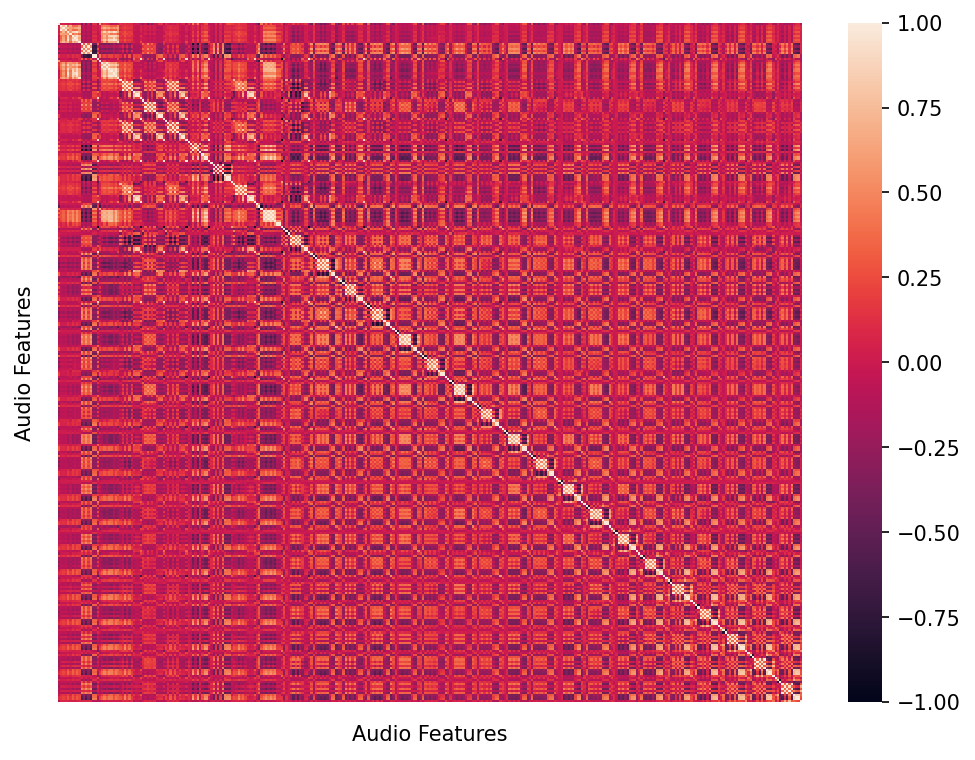

In [5]:
df_corr = df.iloc[:,8:].corr()
plt.figure(figsize=(8, 6))
g = sns.heatmap(df_corr, annot=False, fmt=".1f", vmin=-1, vmax=1)
g.set_yticklabels([])
g.set_xticklabels([])
g.tick_params(left=False, bottom=False)
# plt.title("Correlation Matrix of Audio Features")
plt.xlabel("Audio Features")
plt.ylabel("Audio Features")
plt.show()

In [6]:
def hight_corr_feat_elimination(df_corr, high_corr):
    corr_pairs = df_corr.unstack()
    # order pairs of features with highest correlations
    strong_pairs = []
    for pair in corr_pairs.items():
        if pair[0][0] != pair[0][1] and abs(pair[1]) > high_corr\
            and ((pair[0][1], pair[0][0]), abs(pair[1])) not in strong_pairs:
            strong_pairs.append(((pair[0][0], pair[0][1]), abs(pair[1])))
    strong_pairs.sort(reverse=True, key=lambda x: abs(x[1]))

    eliminated_feats = set()

    for pair in strong_pairs:
        corr = pair[1]
        f1 = pair[0][0]
        f2 = pair[0][1]

        if corr > high_corr and \
            f1 not in eliminated_feats and \
            f2 not in eliminated_feats:
            mean_corr_f1 = np.mean(abs(df_corr[f1].values))
            mean_corr_f2 = np.mean(abs(df_corr[f2].values))

            eliminated_feats.add(f1 if mean_corr_f1 > mean_corr_f2 else f2)

    return eliminated_feats

In [7]:
df_corr = df.iloc[:,8:-1].corr()
eliminated_feats = hight_corr_feat_elimination(df_corr, 0.55)
print(len(eliminated_feats))
print(eliminated_feats)

229
{'kurtosis_mfcc4', 'max_mfcc3', 'min_spec_bw', 'mean_mfcc3', 'skew_mfcc13', 'skew_mfcc18', 'std_spec_rolloff', 'sum_mfcc3', 'min_mfcc1', 'var_mfcc19', 'spikes_spec_bw', 'std_spec_bw', 'std_mfcc15', 'min_mfcc6', 'std_mfcc2', 'skew_mfcc2', 'var_mfcc18', '25thpercentile_mfcc6', 'std_mfcc1', 'mean_rms', 'min_spec_cent', '25thpercentile_mel_spect', 'sum_spec_rolloff', 'max_rms', 'skew_mfcc6', 'median_mfcc19', 'min_mfcc12', 'median_spec_cont', 'min_mel_spect', 'max_mel_spect', 'min_mfcc13', '25thpercentile_mfcc12', 'std_mfcc19', 'min_mfcc15', 'var_spec_cent', 'min_mfcc2', 'std_mfcc10', 'sum_mfcc6', '75thpercentile_mfcc1', 'kurtosis_mfcc3', 'sum_chroma_stft', 'var_rms', 'median_mfcc9', 'sum_spec_bw', '25thpercentile_mfcc10', '25thpercentile_zcr', 'min_mfcc8', 'min_mfcc3', 'std_tonnetz', '25thpercentile_mfcc5', 'spikes_spec_cent', 'std_mfcc11', 'spikes_mfcc5', 'mean_spec_rolloff', 'skew_mfcc11', 'var_tonnetz', 'var_mfcc11', 'sum_mfcc7', 'max_mfcc18', 'spikes_mfcc3', 'spikes_mfcc10', 'media

In [8]:
[df.drop(feat, inplace=True, axis=1) for feat in eliminated_feats]
num_features = len(df.columns)-8
print(f"Number of features after high correlation elimination: {num_features}")
print(set(df.columns[8:]))

Number of features after high correlation elimination: 98
{'max_mfcc6', 'max_mfcc12', 'min_zcr', 'kurtosis_mfcc9', 'var_mel_spect', 'kurtosis_mfcc1', 'kurtosis_mfcc7', 'max_mfcc10', 'mean_mfcc13', 'skew_mfcc10', 'kurtosis_mfcc10', 'max_mfcc11', 'sum_mfcc12', '25thpercentile_spec_cont', 'spikes_mfcc19', '75thpercentile_mfcc17', 'spikes_mfcc11', 'kurtosis_mfcc13', 'kurtosis_mfcc17', 'median_mfcc16', 'kurtosis_mfcc12', 'min_mfcc4', 'spikes_mfcc15', 'mean_mfcc17', 'var_mfcc3', 'median_mfcc4', 'skew_mfcc4', 'max_mfcc8', 'mean_mfcc7', 'mean_mfcc14', 'max_mfcc4', 'sum_mfcc20', '75thpercentile_mfcc20', 'sum_mfcc10', 'spikes_mel_spect', '75thpercentile_tonnetz', '75thpercentile_mfcc11', 'kurtosis_mfcc16', 'kurtosis_mfcc20', 'var_zcr', 'max_mfcc13', 'sum_tonnetz', 'skew_mfcc3', 'kurtosis_mfcc14', '75thpercentile_spec_rolloff', '75thpercentile_mel_spect', '25thpercentile_rms', 'spikes_mfcc2', 'kurtosis_mfcc15', 'median_tonnetz', 'max_spec_cont', '75thpercentile_mfcc7', 'max_mfcc5', 'mean_spec_bw'

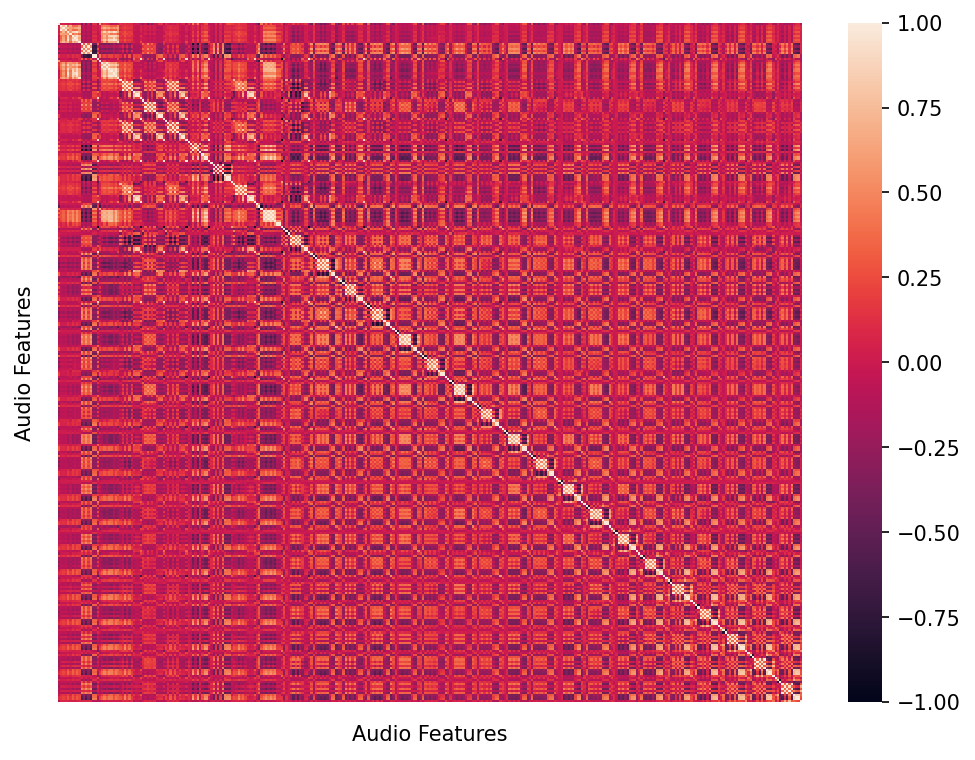

In [8]:
plt.figure(figsize=(8, 6))
df_corr = df.iloc[:,8:].corr()
g = sns.heatmap(df_corr, annot=False, fmt=".2f", vmin=-1, vmax=1)
g.set_yticklabels([])
g.set_xticklabels([])
g.tick_params(left=False, bottom=False)
plt.xlabel("Audio Features")
plt.ylabel("Audio Features")
plt.show()

In [9]:
data = df.iloc[:,8:]
features = df.columns.values[8:]
labels = df["Emotion_Id"].values


In [10]:
def compare_clfs(clfs, data, labels):
    clfs_scores = defaultdict(dict)
    
    for clf in clfs:
        start_time = time.time()
        scores = cross_val_score(clf, data, labels, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=1))
        total_time = time.time() - start_time

        # scores for each fold
        mean_score = np.mean(scores)
        std_score = np.std(scores)

        clfs_scores[clf.__class__.__name__.split("(")[0]] = (mean_score, std_score, total_time)
    
    return clfs_scores

In [11]:
%%capture
clfs = [
    DecisionTree(random_state=1),
    RandomForest(random_state=1, n_estimators=50),
    AdaBoostClassifier(random_state=1, n_estimators=50),
    svm.SVC(decision_function_shape='ovo', random_state=1),
    ExtraTrees(random_state=1, n_estimators=50),
    XGB(random_state=1, objective="multi:softprob"),
    Ridge(random_state=1),
    MLPClassifier(random_state=1)
]

clfs_scores = compare_clfs(clfs, data, labels)

In [12]:
print(f"Classifiers Ordered by Highest Mean Accuracy:")
print(tabulate(
    pd.DataFrame().from_dict(dict(
        sorted(clfs_scores.items(), key=lambda item: item[1][0], reverse=True)
    ), orient="index", columns=["Mean Accuracy", "Std Accuracy", "CV Time"]), headers = 'keys'
))

print(f"Classifiers Ordered by Highest Mean Accuracy:")
print(tabulate(
    pd.DataFrame().from_dict(dict(
        sorted(clfs_scores.items(), key=lambda item: item[1][0], reverse=True)
    ), orient="index", columns=["Mean Accuracy", "Std Accuracy", "CV Time"]), headers='keys', tablefmt="latex_booktabs"
))

Classifiers Ordered by Highest Mean Accuracy:
                          Mean Accuracy    Std Accuracy     CV Time
----------------------  ---------------  --------------  ----------
XGBClassifier                  0.617972      0.0136354   17.6284
RandomForestClassifier         0.578741      0.0107318    7.45116
RidgeClassifier                0.565536      0.0141583    0.0786786
ExtraTreesClassifier           0.561021      0.00534552   1.83141
AdaBoostClassifier             0.520161      0.00821762  12.2053
SVC                            0.504068      0.0180651    5.08107
DecisionTreeClassifier         0.450731      0.0222085    1.88665
MLPClassifier                  0.446208      0.0277934    4.82165
Classifiers Ordered by Highest Mean Accuracy:
\begin{tabular}{lrrr}
\toprule
                        &   Mean Accuracy &   Std Accuracy &    CV Time \\
\midrule
 XGBClassifier          &        0.617972 &     0.0136354  & 17.6284    \\
 RandomForestClassifier &        0.578741 &     0.0107

In [13]:
feat_elim = {}
df_train = data.copy()
for i in tqdm(range(num_features-1, 0, -1)):
    sfs1 = sfs(RandomForest(random_state=1, n_estimators=50), k_features=i, forward=False, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=1), verbose=0, n_jobs=-1)
    sfs1 = sfs1.fit(df_train, labels)
    feat_names = set(sfs1.k_feature_names_)
    eliminated_f = [feat for feat in features if feat not in feat_names and feat not in feat_elim][0]
    feat_elim[eliminated_f] = sfs1.k_score_
    df_train.drop(eliminated_f, inplace=True, axis=1)

100%|██████████| 97/97 [1:16:26<00:00, 47.29s/it]


In [ ]:
 XGBoost                &        0.617$\pm$0.013  & 17.628 \\
 Random Forest          &        0.578$\pm$0.010  &  7.451 \\
 Ridge                  &        0.565$\pm$0.014  &  0.078 \\
 Extra Trees            &        0.561$\pm$0.005 &  1.831  \\
 AdaBoost               &        0.520$\pm$0.008 & 12.205  \\
 C-Support Vector       &        0.504$\pm$0.018  &  5.081 \\
 DecisionTree           &        0.450$\pm$0.022  &  1.886 \\
 Multi-layer Perceptron &        0.446$\pm$0.027  &  4.821 \\

In [14]:
feat_elim_df = pd.DataFrame().from_dict(feat_elim, orient="index", columns=["Accuracy"])
feat_elim_df.to_csv('pre_feat_elim.csv')
print(tabulate(feat_elim_df.iloc[:10,:], headers = 'keys'))

                         Accuracy
---------------------  ----------
kurtosis_mfcc14          0.58814
var_mfcc6                0.588324
max_mfcc12               0.588322
sum_mfcc4                0.589043
max_mfcc6                0.586875
kurtosis_mfcc19          0.586329
75thpercentile_mfcc18    0.587958
skew_mfcc5               0.588139
spikes_mfcc13            0.588499
mean_mfcc7               0.587781


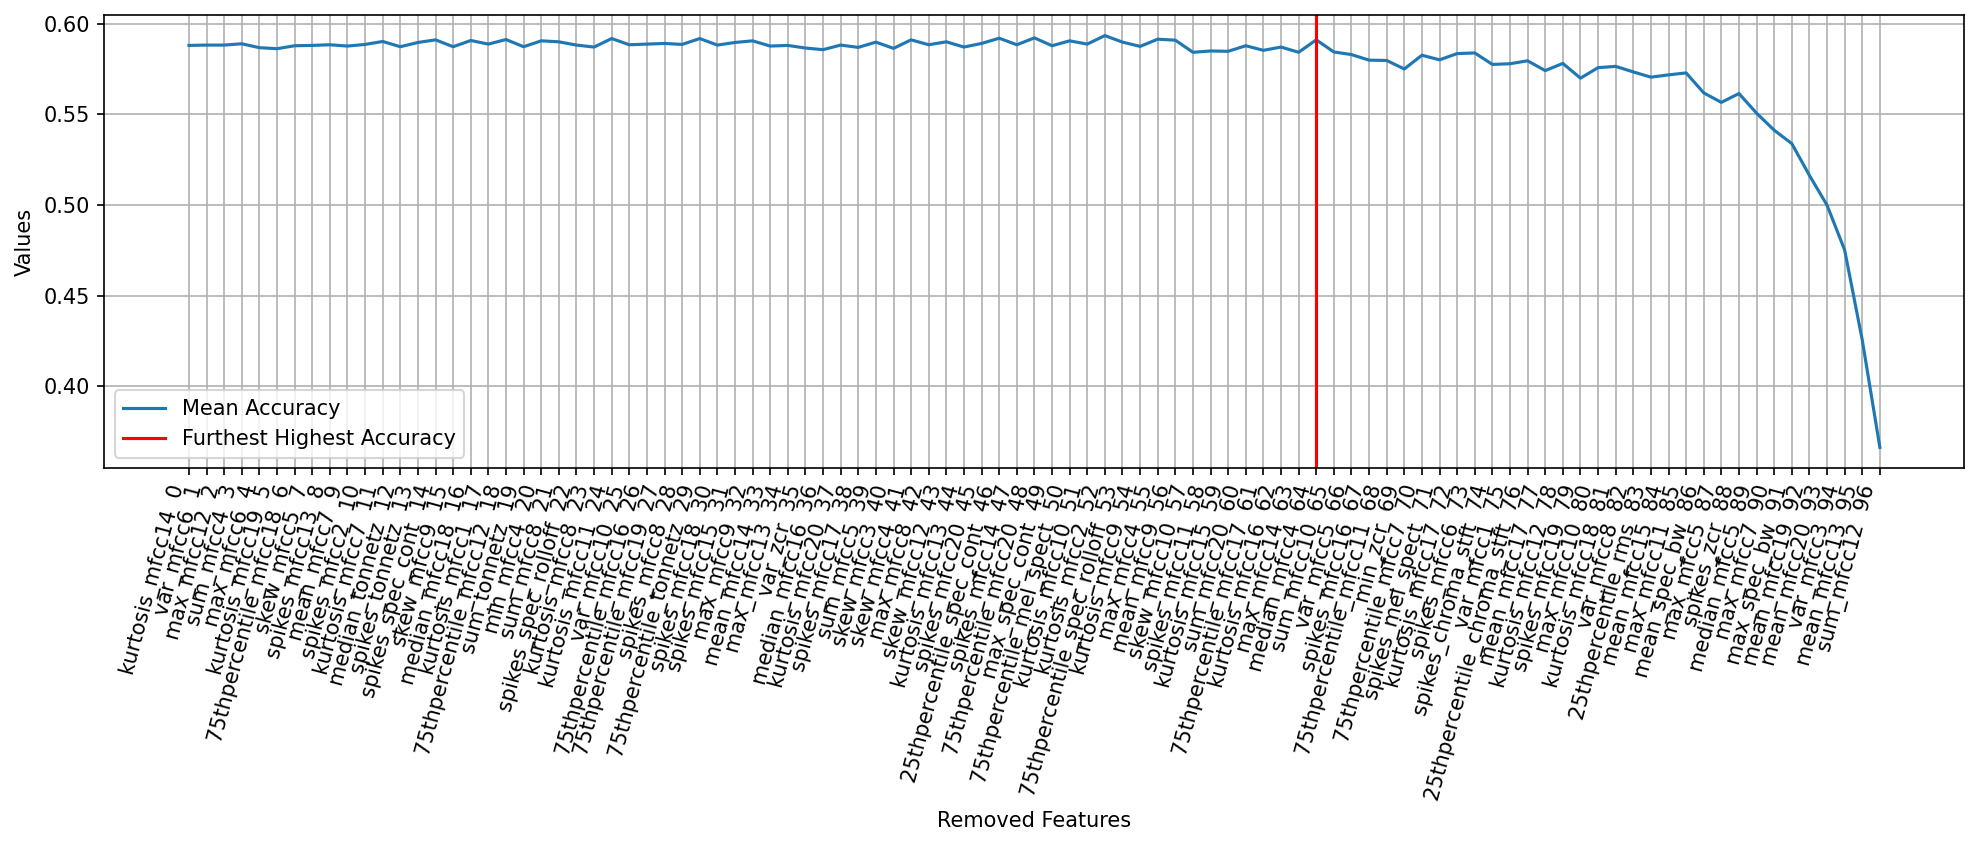

In [15]:
feat_elim_df = pd.read_csv("pre_feat_elim.csv", index_col=0)
max_acc = 0
max_feat = None
for feat, columns in feat_elim_df.iterrows():
    if columns["Accuracy"] >= max_acc*0.9935:
        max_acc =  columns["Accuracy"]
        max_feat = feat
elim_feats = []
for feat, columns in feat_elim_df.iterrows():
    elim_feats.append(feat)
    if feat == max_feat:
        break
idx = len(elim_feats) - 1
fig = plt.figure(figsize=(16,4))
ax = plt.axes()
plt.ylabel("Values")
plt.xlabel("Removed Features")
plt.grid()
plt.setp(ax.get_xticklabels(), ha="right", rotation=75)
x_labels = [f"{feat_elim_df.index.values[i]}  {i}" for i in range(len(feat_elim_df.index.values))]
ax.plot(x_labels, feat_elim_df['Accuracy'].values, label="Mean Accuracy")
ax.axvline(x = idx, color = 'r', label="Furthest Highest Accuracy")
plt.legend()

In [16]:
print('Backward Feature Elimination with Propagation"\n')
print(f"Number of Eliminated Features Using:\n\t-Accuracy as the Decider Metric: {len(elim_feats)}")

Backward Feature Elimination with Propagation"

Number of Eliminated Features Using:
	-Accuracy as the Decider Metric: 65


In [17]:
data_elim_feats = data.copy(deep=True)
[data_elim_feats.drop(feat, inplace=True, axis=1) for feat in elim_feats]
num_features = len(data_elim_feats.columns)
features = data_elim_feats.columns.values
print(f"Number of Features After Eliminating Common Features: {num_features}")
print(set(features))

Number of Features After Eliminating Common Features: 33
{'min_zcr', '75thpercentile_mfcc7', 'max_mfcc5', 'mean_spec_bw', 'mean_mfcc20', 'var_mel_spect', 'sum_mfcc10', '75thpercentile_mfcc11', 'max_mfcc10', 'mean_mfcc13', 'var_mfcc5', 'max_mfcc7', 'spikes_mfcc16', 'spikes_zcr', 'max_mfcc11', 'sum_mfcc12', 'spikes_mfcc19', 'spikes_mfcc6', 'kurtosis_mfcc18', 'var_mfcc1', 'median_mfcc5', '25thpercentile_chroma_stft', 'kurtosis_mfcc17', 'var_mfcc8', 'mean_mfcc15', 'mean_mfcc19', 'kurtosis_mfcc12', 'spikes_chroma_stft', '25thpercentile_rms', 'mean_mfcc17', 'var_mfcc3', 'max_spec_bw', 'spikes_mel_spect'}


In [18]:
def get_metrics(y_labels, y_pred, folds_size, train_times, prediction_times, draw_corr_matrix=True):
    accs = []
    i = 0
    for f_i in range(5):
      acc = round(metrics.accuracy_score(
          y_labels[i:i+folds_size[f_i]], y_pred[i:i+folds_size[f_i]]) * 100, 2)
      print(f"Accuracy for fold {f_i}: {acc}%")
      accs.append(acc)
      i += folds_size[f_i]

    table = [
        ["Accuracy",
            f"{round(metrics.accuracy_score(y_labels, y_pred) * 100, 2)}+-{round(np.std(accs), 2)}"],
        ["F1 score macro", round(metrics.f1_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Precision", round(metrics.precision_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Recall", round(metrics.recall_score(
            y_labels, y_pred, average='macro') * 100, 2)],
        ["Matthews corrcoef", round(
            metrics.matthews_corrcoef(y_labels, y_pred), 3)],
        ["Training Time", f"{round(np.sum(train_times), 2)}+-{round(np.std(train_times), 2)}"],
        ["Prediction Time", f"{round(np.sum(prediction_times), 2)}+-{round(np.std(prediction_times), 2)}"],
    ]
    print()
    print(tabulate(table, headers=["Metric", "Value"]))
    print()
    print(metrics.classification_report(y_labels, y_pred))

    if draw_corr_matrix:
        ticks = ['0 - angry', '1 - happy', '2 - neutral', '3 - sad']
        cm = metrics.confusion_matrix(y_labels, y_pred, normalize='all')
        plt.figure(figsize=(6, 6))
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=ticks, yticklabels=ticks)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Emotion Label")
        plt.ylabel("Real Emotion Label")
        plt.yticks(rotation=0)
        plt.show()


In [19]:
def categorical_cross_validation(get_new_model, X, y, cv=5, draw_corr_matrix=True):
    train_times = []
    prediction_times = []
    folds_size = []

    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1)
    
    all_y_pred = []
    all_y_labels = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        model = get_new_model()
        
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]

        folds_size.append(len(y_test))

        start_time = time.time()
        model.fit(X_train, y_train.values.ravel())
        train_times.append(time.time() - start_time)

        start_time = time.time()
        y_pred = model.predict(X_test)
        prediction_times.append(time.time() - start_time)

        all_y_pred.extend(y_pred)
        all_y_labels.extend(y_test.values.ravel())

        fold_no = fold_no + 1

    get_metrics(all_y_labels, all_y_pred, folds_size, train_times, prediction_times, draw_corr_matrix)

# All features

In [20]:
df = pd.read_csv(PREPROCESSED_EXTRACTED_FEATURES_FILE)
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df.loc[df['Emotion'] == 'excited', 'Emotion'] = 'happy'
df.loc[df['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']}).sort_values("Emotion_Id")
df[df.columns[8:]].shape

(5531, 327)

Accuracy for fold 0: 59.26%
Accuracy for fold 1: 59.67%
Accuracy for fold 2: 60.04%
Accuracy for fold 3: 58.5%
Accuracy for fold 4: 58.23%

Metric             Value
-----------------  -----------
Accuracy           59.14+-0.68
F1 score macro     59.86
Precision          60.67
Recall             59.48
Matthews corrcoef  0.446
Training Time      15.34+-0.1
Prediction Time    0.07+-0.0

              precision    recall  f1-score   support

           0       0.68      0.58      0.62      1103
           1       0.55      0.51      0.53      1636
           2       0.64      0.65      0.65      1084
           3       0.55      0.64      0.59      1708

    accuracy                           0.59      5531
   macro avg       0.61      0.59      0.60      5531
weighted avg       0.60      0.59      0.59      5531



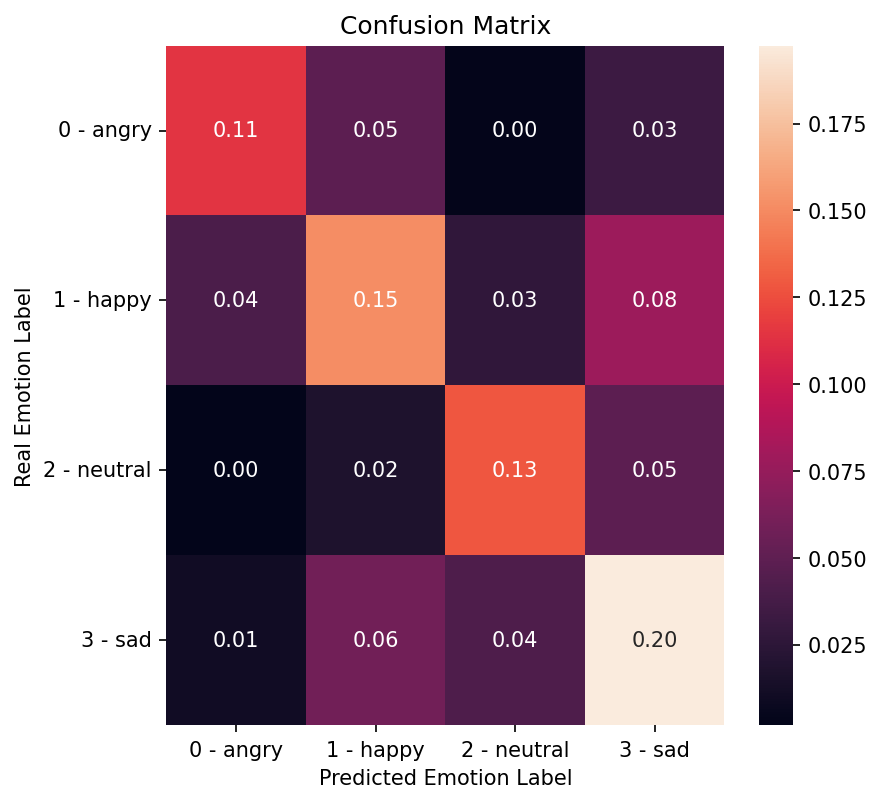

In [21]:
def get_new_model():
    return RandomForest(random_state=1, n_estimators=50)
    
categorical_cross_validation(get_new_model, df.iloc[:,8:], df.iloc[:,4:5])

## Features Obtained After High Correlation Elimination

In [22]:
data.shape

(5531, 98)

Accuracy for fold 0: 56.28%
Accuracy for fold 1: 58.77%
Accuracy for fold 2: 59.31%
Accuracy for fold 3: 57.69%
Accuracy for fold 4: 57.32%

Metric             Value
-----------------  -----------
Accuracy           57.87+-1.07
F1 score macro     58.69
Precision          59.35
Recall             58.43
Matthews corrcoef  0.429
Training Time      7.89+-0.08
Prediction Time    0.06+-0.0

              precision    recall  f1-score   support

           0       0.67      0.57      0.62      1103
           1       0.54      0.49      0.51      1636
           2       0.63      0.65      0.64      1084
           3       0.54      0.62      0.58      1708

    accuracy                           0.58      5531
   macro avg       0.59      0.58      0.59      5531
weighted avg       0.58      0.58      0.58      5531



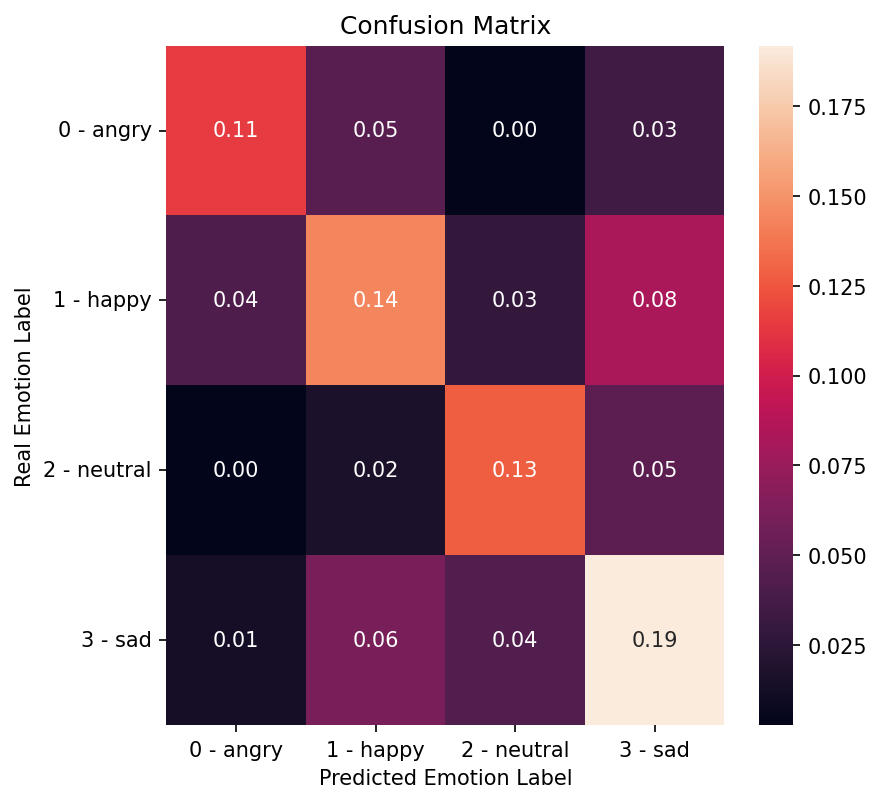

In [23]:
categorical_cross_validation(get_new_model, data, df.iloc[:,4:5])

## Features Obtained After High Correlation Elimination and Backwards Selection

In [24]:
data_elim_feats.shape

(5531, 33)

Accuracy for fold 0: 60.34%
Accuracy for fold 1: 58.41%
Accuracy for fold 2: 60.04%
Accuracy for fold 3: 59.31%
Accuracy for fold 4: 57.5%

Metric             Value
-----------------  -----------
Accuracy           59.12+-1.05
F1 score macro     59.87
Precision          60.3
Recall             59.71
Matthews corrcoef  0.446
Training Time      4.29+-0.03
Prediction Time    0.06+-0.0

              precision    recall  f1-score   support

           0       0.66      0.59      0.62      1103
           1       0.56      0.51      0.53      1636
           2       0.64      0.66      0.65      1084
           3       0.55      0.62      0.59      1708

    accuracy                           0.59      5531
   macro avg       0.60      0.60      0.60      5531
weighted avg       0.59      0.59      0.59      5531



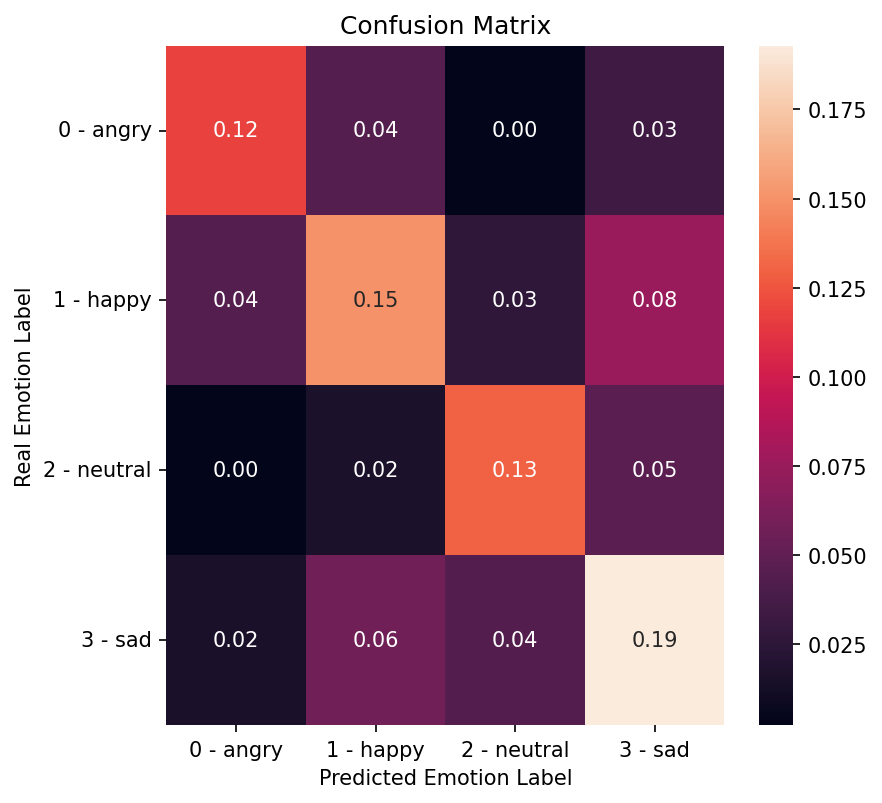

In [25]:
categorical_cross_validation(get_new_model, data_elim_feats, df.iloc[:,4:5])